In [94]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import itertools
# PyMC imports
import pymc as pm
import arviz as az
import seaborn as sb
# Scipy imports
from scipy.optimize import fsolve
from scipy.integrate import nquad, quad
from scipy.stats import norm
# other
import harmonic as hm

## Harmonic Mean Estimator

### $$ \rho = \mathbb{E}_{p(\theta \mid y)}\biggl[ \frac{1}{\mathcal{L}(\theta)} \biggr] = \int d\theta \frac{1}{\mathcal{L}(\theta)}p(\theta \mid y) = \int \frac{1}{\mathcal{L}(\theta)} \frac{\mathcal{L}(\theta)\pi(\theta)}{z} = \frac{1}{z} $$


In [95]:
def HME_V(likelihood, prior):
    pass 

def HME(L, P):
    pass

Given a Bayesian Linear Regression model
$$
y_{i} = x_{i}\mathbf{\theta_{1}} + \epsilon
$$

Our parameter space is $\mathbf{\Theta} = \{\mathbf{\theta_{1}}, \log(\sigma^{2})\} \equiv \{\mathbf{\theta_{1}}, \theta_{2}\}$

We have that the likilihood is given by
$$
P(\mathbf{y}|\mathbf{\Theta}) = P(\mathbf{y}|\mathbf{X, \Theta}) = \frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma^{2}}}\exp\biggl[-\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} \biggr]
$$

Our prior is given by
$$
P(\mathbf{\Theta}) = \frac{1}{(\sqrt{2\pi})^{N}\sqrt{|S_{1}|}}\exp\biggl[-\frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}}\biggr]\frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma_{2}^{2}}}\exp\biggl[-\frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}\biggr]
$$

The Hamiltonian is
\begin{align*}
H(\mathbf{\Theta}) &= -\log(P(\mathbf{y}|\mathbf{\Theta})P(\mathbf{\Theta})) \\
&= -\log\biggl(\frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma^{2}}}\exp\biggl[-\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} \biggr]\frac{1}{(\sqrt{2\pi})^{N}\sqrt{|S_{1}|}}\exp\biggl[-\frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}}\biggr]\frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma_{2}^{2}}}\exp\biggl[-\frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}\biggr]\biggr) \\
&= -\log\biggl(\frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma^{2}}}\frac{1}{(\sqrt{2\pi})^{N}\sqrt{|S_{1}|}}\frac{1}{(\sqrt{2\pi})^{N}\sqrt{\sigma_{2}^{2}}}\exp\biggl[-\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} \biggr]\exp\biggl[-\frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}}\biggr]\exp\biggl[-\frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}\biggr]\biggr) \\
&= -\log\biggl(\frac{1}{(\sqrt{2\pi})^{3N}}\frac{1}{\sqrt{\sigma^{2}|S_{1}|\sigma_{2}^{2}}}\exp\biggl[-\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} \biggr]\exp\biggl[-\frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}}\biggr]\exp\biggl[-\frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}\biggr]\biggr) \\
&= \frac{N}{2}3\log(2\pi) + \frac{1}{2}(\log(\sigma^{2}) + \log(|S_{1}|) + \log(\sigma_{2}^{2})) + \frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} + \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}} + \frac{\theta_{2}^{2}}{2\sigma_{2}^{2}} \\
&= \frac{N}{2}3\log(2\pi) + \frac{1}{2}(\theta_{2} + \log(|S_{1}|) + \log(\sigma_{2}^{2})) + \frac{1}{2}\biggl((\mathbf{y} - \mathbf{X\theta_{1}})^{T}\exp(-\theta_{2})(\mathbf{y} - \mathbf{X\theta_{1}}) + \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{S_{1}} + \frac{\theta_{2}^{2}}{\sigma_{2}^{2}}\biggr) \\
&= \frac{N}{2}3\log(2\pi) + \frac{1}{2}(\theta_{2} + \log(|S_{1}|) + \log(\sigma_{2}^{2})) + \frac{1}{2}\biggl(\exp(-\theta_{2})(\mathbf{y}^{T}\mathbf{y} - 2(\mathbf{\theta_{1}X})^{T}\mathbf{y} + (\mathbf{\theta_{1}X})^{T}\mathbf{\theta_{1}X}) + \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{S_{1}} + \frac{\theta_{2}^{2}}{\sigma_{2}^{2}}\biggr)
\end{align*}

In [96]:
def Hamiltoninan(THETA: np.ndarray, MODEL: np.ndarray) -> np.ndarray:
    # tht1 would be a vector of thetas
    # but in this case, its just a single value
    tht1 = THETA[0]
    tht2 = THETA[1]

    # x_ should be a matrix
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    # Should be a covariance matrix
    # but in this case, its just a scalar
    s_1 = MODEL[2]
    # sig1 = MODEL[3]
    sig2 = MODEL[4]
    sig2 = sig2**2

    y_hat = y_vec - (tht1*x_mat)

    N = len(y_vec)

    log_terms = ( N * 3 *np.log(2*np.pi)) + ( np.log(s_1) + np.log(sig2))
    exp_term = np.exp(-tht2)* (y_hat.T @ y_hat)
    prior_terms = ((tht1**2)/s_1) + ((tht2**2)/sig2)

    H = 0.5 * (log_terms + exp_term + prior_terms)

    return np.array([H])

Taking the derivative of the Hamiltonian we get
$$
\nabla H(\mathbf{\Theta}) = \biggl\langle \frac{\partial H}{\partial \mathbf{\theta_{1}}}, \frac{\partial H}{\partial \theta_{2}} \biggr\rangle 
$$
Taking the derivative with respect to $\mathbf{\theta_{1}}$
\begin{align*}
\frac{\partial H}{\partial \mathbf{\theta_{1}}} &= \frac{1}{2}\biggl(\exp(-\theta_{2})( - 2X^{T}\mathbf{y} + 2\mathbf{X}^{T}\mathbf{\theta_{1}X}) + 2\frac{\mathbf{\theta_{1}}}{S_{1}} \biggr) \\
&= -\exp(-\theta_{2})( \mathbf{X}^{T}(\mathbf{y} - \mathbf{X}\mathbf{\theta_{1}})) + \frac{\mathbf{\theta_{1}}}{S_{1}} \\
&= -\exp(-\theta_{2}) \mathbf{X}^{T}\hat{\mathbf{y}} + \frac{\mathbf{\theta_{1}}}{S_{1}}
\end{align*}

Taking the derivative with respect to $\theta_{1}$
\begin{align*}
\frac{\partial H}{\partial \theta_{2}} &=  \frac{N}{2} - \frac{1}{2}(\mathbf{y} - \mathbf{X\theta_{1}})^{T}\exp(-\theta_{2})(\mathbf{y} - \mathbf{X\theta_{1}}) + \frac{\theta_{2}}{\sigma_{2}^{2}} \\ 
&= -\frac{\exp(-\theta_{2})}{2}\hat{\mathbf{y}}^{T}\hat{\mathbf{y}} + \frac{N}{2}+ \frac{\theta_{2}}{\sigma_{2}^{2}}
\end{align*}

So we have that 
$$
\nabla H(\mathbf{\Theta}) = \biggl\langle -\exp(-\theta_{2}) \mathbf{X}^{T}\hat{\mathbf{y}} + \frac{\mathbf{\theta_{1}}}{S_{1}}, -\frac{\exp(-\theta_{2})}{2}\hat{\mathbf{y}}^{T}\hat{\mathbf{y}} + \frac{N}{2} + \frac{\theta_{2}}{\sigma_{2}^{2}} \biggr\rangle 
$$

In the case that $\sigma$ is known

$$
 H(\mathbf{\Theta}) = \frac{N}{2}3\log(2\pi) + \frac{1}{2}(\log(\sigma^{2}) + \log(|S_{1}|) + \log(\sigma_{2}^{2})) + \frac{1}{2}\biggl(\frac{(\mathbf{y}^{T}\mathbf{y} - 2(\mathbf{\theta_{1}X})^{T}\mathbf{y} + (\mathbf{\theta_{1}X})^{T}\mathbf{\theta_{1}X})}{\sigma^{2}} + \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{S_{1}} + \frac{\log(\sigma^{2})^{2}}{\sigma_{2}^{2}}\biggr)
$$

In [97]:
def Hamiltoninan1D(THETA: np.ndarray, MODEL: np.ndarray) -> np.ndarray:
    tht1 = THETA

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    s_1 = MODEL[2]
    sig1 = MODEL[3]
    sig1 = sig1**2
    sig2 = MODEL[4]
    sig2 = sig2**2

    y_hat = y_vec - (tht1*x_mat)

    N = len(y_vec)

    log_terms = ( N * 3 *np.log(2*np.pi)) + ( np.log(s_1) + np.log(sig2))
    exp_term = (y_hat.T @ y_hat) / sig2
    prior_terms = ((tht1.T @ tht1)/s_1) + ((np.log(sig1)**2 )/ sig2)

    H = 0.5 * (log_terms + exp_term + prior_terms)

    return np.array([H])

Taking the derivative with respect to $\mathbf{\theta_{1}}$
\begin{align*}
\frac{\partial H}{\partial \mathbf{\theta_{1}}} &= \frac{1}{2}\biggl(\frac{( - 2X^{T}\mathbf{y} + 2\mathbf{X}^{T}\mathbf{\theta_{1}X})}{\sigma^{2}} + 2\frac{\mathbf{\theta_{1}}}{S_{1}} \biggr) \\
&= -\frac{(\mathbf{X}^{T}(\mathbf{y} - \mathbf{X}\mathbf{\theta_{1}}))}{\sigma^{2}} + \frac{\mathbf{\theta_{1}}}{S_{1}} \\
&= -\frac{\mathbf{X}^{T}\hat{\mathbf{y}}}{\sigma^{2}} + \frac{\mathbf{\theta_{1}}}{S_{1}}
\end{align*}

In [98]:
def HamiltoninanPrime1D(THETA: np.ndarray, MODEL: np.ndarray) -> np.ndarray:
    # tht1 would be a vector of thetas
    # but in this case, its just a single value
    tht1 = THETA[0]

    # x_ should be a matrix
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    # Should be a covariance matrix
    # but in this case, its just a scalar
    s_1 = MODEL[2]
    sig1 = MODEL[3]
    sig1 = sig1**2

    y_hat = y_vec - (tht1*x_mat)

    term1 = -x_mat.T @ y_hat
    term1 /= sig1

    return np.array([term1 + (tht1 / s_1)])

Taking the second derivative we get

\begin{align*}
\frac{\partial^{2} H}{\partial \mathbf{\theta_{1}}^{2}} &= \frac{\mathbf{X}^{T}\mathbf{X}}{\sigma^{2}} + \frac{1}{S_{1}}\\
\end{align*}

In [99]:
def HamiltoninanDPrime1D(THETA: np.ndarray, MODEL: np.ndarray) -> np.ndarray:
    # tht1 would be a vector of thetas
    # but in this case, its just a single value
    tht1 = THETA[0]

    # x_ should be a matrix
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    # Should be a covariance matrix
    # but in this case, its just a scalar
    s_1 = MODEL[2]
    sig1 = MODEL[3]
    sig1 = sig1**2

    return np.array([((x_mat.T @ x_mat) / sig1) + (1 / s_1)])

We aim to find the Maximum A Posteriori (MAP) estimate, which is the point where the gradient of the Hamiltonian, ( H(\mathbf{\Theta}) ), is zero:

$$ \nabla H(\mathbf{\Theta}) = 0 $$

At this point, the MAP values $ \mathbf{\theta_{10}} $ and $ \theta_{20} $ make the first derivative zero.

If the standard deviation $ \sigma $ is known, we can solve for $ \mathbf{\theta_{10}} $ without needing $ \theta_{20} $, as $ \sigma $ is known. This simplifies our system to one dimension:

\begin{align*} 
\frac{\partial H}{\partial \mathbf{\theta_{1}}} &= 0 \\
&= -\frac{\mathbf{X}^{T}(\mathbf{y} - \mathbf{X}\mathbf{\theta_{10}})}{\sigma^{2}} + \frac{\mathbf{\theta_{10}}}{S_{1}} \\
&= \frac{-\mathbf{X}^{T}\mathbf{y} + \mathbf{X}^{T}X\mathbf{\theta_{10}}}{\sigma^{2}} + \frac{\mathbf{\theta_{10}}}{S_{1}} \\ 
&= -\frac{\mathbf{X}^{T}\mathbf{y}}{\sigma^{2}} + \mathbf{\theta_{10}}\left(\frac{\mathbf{X}^{T}\mathbf{X}}{\sigma^{2}} + \frac{1}{S_{1}}\right) 
\end{align*} 

Thus we have
$$
\mathbf{\theta}_{10} = \frac{\mathbf{X}^{T}\mathbf{y}}{\sigma^{2}}\left(\frac{\mathbf{X}^{T}\mathbf{X}}{\sigma^{2}} + \frac{1}{S_{1}}\right) ^{-1}
$$

In [100]:
def MAP_SOLUTIONS( MODEL: np.ndarray) -> np.ndarray:
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    s_1 = MODEL[2]
    sig1 = MODEL[3]
    sig1 = sig1**2

    inv_term = ((x_mat.T @ x_mat) / sig1) + (1/s_1)
    inv_term = 1 / inv_term
    map_tht = inv_term * (x_mat.T @ y_vec) / sig1

    return np.array([map_tht])


In [101]:
np.random.seed(42)
N = 200
X_vec = np.random.uniform(-10,10,N)
true_beta = 2
true_sigma = 5
epsilon = np.random.randn(N) * true_sigma
y_vec = X_vec * true_beta + epsilon
S_1 = 400
sig2 = 10

In [102]:
map_sol = MAP_SOLUTIONS([X_vec, y_vec, S_1, true_sigma, sig2])
map_sol

array([1.97741588])

In [103]:
j = -HamiltoninanPrime1D(map_sol, [X_vec, y_vec, S_1, true_sigma, sig2])
j

array([5.74809297e-14])

In [104]:
Dinv = HamiltoninanDPrime1D(map_sol, [X_vec, y_vec, S_1, true_sigma, sig2])
D = 1 / Dinv

In [105]:
H0map = Hamiltoninan1D(map_sol, [X_vec, y_vec, S_1, true_sigma, sig2])
H0map

array([580.17291046])

In [106]:
circ = np.log(2 * np.pi * D)
circ

array([-3.78868142])

In [107]:
logZ = -H0map + circ
print(logZ)
Z = np.exp(logZ)
print(Z)

[-583.96159188]
[2.44738901e-254]


In [108]:
def Q(THETA: np.ndarray, MODEL: np.ndarray) -> np.ndarray:
    theta = np.array([THETA])
    H = Hamiltoninan1D(theta, MODEL)
    return np.exp(-H)

In [109]:
N_Z, _ = nquad(Q, [[-np.inf, np.inf]], args=[[X_vec, y_vec, S_1, true_sigma, sig2]])
print(N_Z)
print(np.log(N_Z))

2.4007830063973078e-253
-581.6782335906829


/var/folders/xv/8r23mzm112ggs6n6_tvn5cn00000gn/T/ipykernel_81850/220309348.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q_vals[i] = Q(thetas[i], [X_vec, y_vec, S_1, true_sigma, sig2])


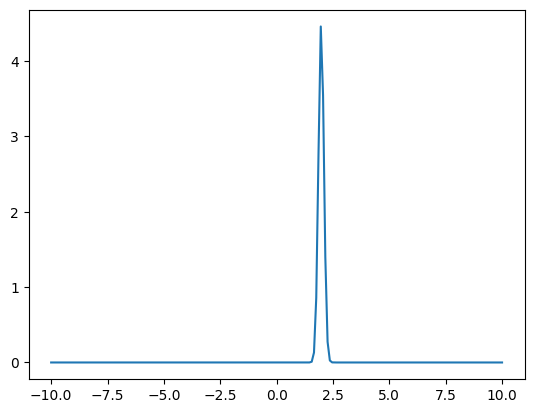

In [110]:
# plot the likelihood
thetas = np.linspace(-10, 10, N)

Q_vals = np.zeros(N)
for i in range(N):
    Q_vals[i] = Q(thetas[i], [X_vec, y_vec, S_1, true_sigma, sig2])
    Q_vals[i] /= N_Z

plt.plot(thetas, Q_vals)
plt.show()

/var/folders/xv/8r23mzm112ggs6n6_tvn5cn00000gn/T/ipykernel_81850/21293745.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q_vals[i] = Q(thetas[i], [X_vec, y_vec, S_1, true_sigma, sig2])
/var/folders/xv/8r23mzm112ggs6n6_tvn5cn00000gn/T/ipykernel_81850/21293745.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q_vals[i] /= Z


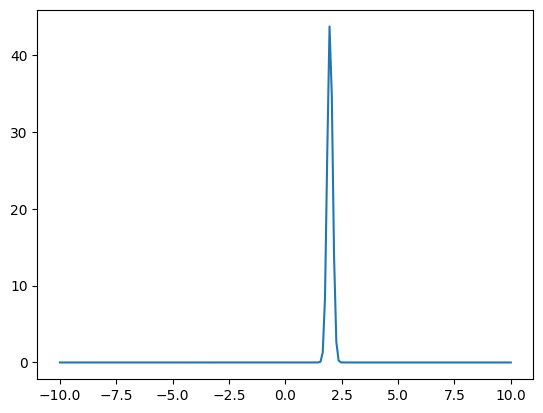

In [112]:
for i in range(N):
    Q_vals[i] = Q(thetas[i], [X_vec, y_vec, S_1, true_sigma, sig2])
    Q_vals[i] /= Z

plt.plot(thetas, Q_vals)
plt.show()